# **Bhadale IT - Startup, Good Business and Governance based Tool**

This demonstrates the Good Governance tool usage with a sample related to bribe:

•	Initializes Org framework, Ops registry, Product registry, and an in-memory ledger (SQLite).

•	Implements OpsAgent and QAI Advisor stubs (policy checks + simple risk/impact models).

•	Simulates two scenarios: REJECT_BRIBE and ACCEPT_BRIBE (off-books).

•	Produces a summary table, prints alerts/logs, and draws charts for board presentation.



Org, Ops, Products initialized (demo).


,sku,name,cost,price
0,QAI-EDGE-001,QAI Edge Kit - SME,5000,7000
1,AUT-HOUSE-001,Affordable Home Kit,1500,2200


Recorded traceable transaction: TX-20250905062319

=== OpsAgent Decision on Proposed Off-Books Bribe ===


/tmp/ipython-input-2208107852.py:67: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  deal_tx_id = "TX-" + datetime.utcnow().strftime("%Y%m%d%H%M%S")
/tmp/ipython-input-2208107852.py:63: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  (tx_id, datetime.utcnow().isoformat(), amount, currency, from_entity, to_entity, description, int(traceable)))


,block,escalate_to,reason,banker_flag
0,True,[BoardOps],Policy violation: off-books bribe proposed,True



=== Summary Table (REJECT vs ACCEPT off-books) ===


,scenario,cash_end,contractor_spend,quality_index,morale_index,schedule_weeks,banker_score,expected_investigation_cost,lost_future_sales,total_expected_impact
0,REJECT_BRIBE,"6,000,000","2,000,000",100.0,100.0,24.0,0.060,"69,000","43,200","412,200"
1,ACCEPT_BRIBE_OFFBOOKS,"5,800,000","1,800,000",92.0,94.0,25.2,0.160,"184,000","187,200","641,200"



--- Logs: ACCEPT_BRIBE_OFFBOOKS scenario ---
- Deal of 5000000.00 received; cash now 6000000.00
- Planned contractor spend: 2000000.00
- Off-books (non-traceable) cash bribe paid: 200000.00 (not recorded)
- Contractor after: 1800000.00 reduction%: 0.100
- Quality: 92.0, Morale: 94.0, Schedule(weeks): 25.2
Banker suspicion score: 0.1600 -> flagged: True
Expected investigation & remediation cost (est): 184000.00
Estimated lost future sales: 187200.00
Total expected impact (estimate): 641200.00


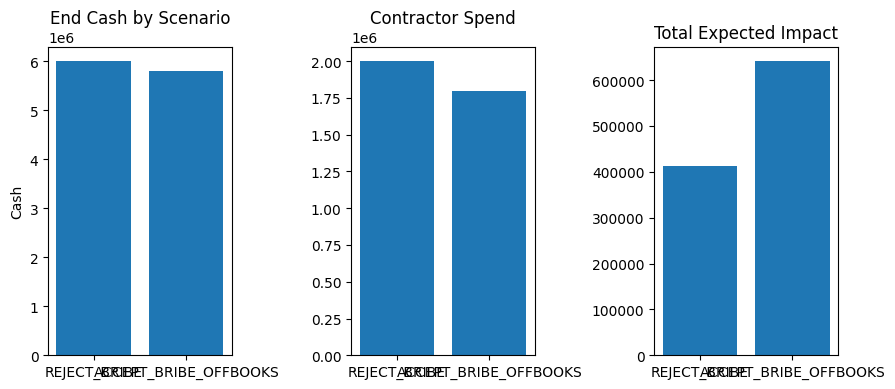

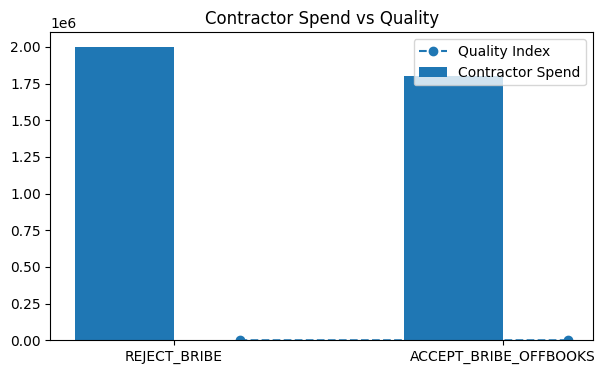


=== Traceable Ledger (transactions) ===


,tx_id,timestamp,amount,currency,from_entity,to_entity,description,traceable
0,TX-20250905062319,2025-09-05T06:23:19.276354,5000000.0,INR,GRANTOR,BHADALE-CASH,Government deal payment - milestone 1,1


In [2]:
# Demo: Governance / Bribe Simulation (single-cell, self-contained)
# - No persistent project folder; uses in-memory ledger to avoid file-system issues.
# - Shows Org/Ops/Product init, OpsAgent + QAI advisor, two scenarios, alerts, and charts.
# Run in Google Colab or a Jupyter environment.

import sqlite3
import json
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# -------------------------
# 1) Initialize Org, Ops, Products (in-memory structures)
# -------------------------
ORG = {
    "org_name": "Bhadale IT",
    "org_id": "BHADALE-ORG-001",
    "policies": {
        "no_off_books": True,
        "require_qai_validation_for_big_deals": True,
        "bribe_zero_tolerance": True
    }
}

OPS = {
    "ops_list": ["FinOps", "HRops", "RiskOps", "ClientOps", "BoardOps", "AuditOps"],
    "ops_agent_name": "OpsAgent-v1"
}

PRODUCTS = [
    {"sku": "QAI-EDGE-001", "name": "QAI Edge Kit - SME", "cost": 5000, "price": 7000},
    {"sku": "AUT-HOUSE-001", "name": "Affordable Home Kit", "cost": 1500, "price": 2200}
]

print("Org, Ops, Products initialized (demo).")
display(pd.DataFrame(PRODUCTS))

# -------------------------
# 2) In-memory ledger (SQLite) - traceable transactions table
# -------------------------
conn = sqlite3.connect(":memory:")
cur = conn.cursor()
cur.execute("""
CREATE TABLE transactions (
    tx_id TEXT PRIMARY KEY,
    timestamp TEXT,
    amount REAL,
    currency TEXT,
    from_entity TEXT,
    to_entity TEXT,
    description TEXT,
    traceable INTEGER
)
""")
conn.commit()

def record_tx(tx_id, amount, description, traceable=1, from_entity="GRANTOR", to_entity="BHADALE-CASH", currency="INR"):
    cur.execute("""INSERT OR REPLACE INTO transactions
                (tx_id,timestamp,amount,currency,from_entity,to_entity,description,traceable)
                VALUES (?,?,?,?,?,?,?,?)""",
                (tx_id, datetime.utcnow().isoformat(), amount, currency, from_entity, to_entity, description, int(traceable)))
    conn.commit()

# Add sample traceable deal payment (milestone)
deal_tx_id = "TX-" + datetime.utcnow().strftime("%Y%m%d%H%M%S")
record_tx(deal_tx_id, 5_000_000.0, "Government deal payment - milestone 1", traceable=1)
print("Recorded traceable transaction:", deal_tx_id)

# -------------------------
# 3) OpsAgent & QAI Advisor stubs
# -------------------------
def opsagent_check_bribe_proposal(bribe_amount, traceable_flag, deal_value, org_config):
    """
    Returns decision dict: block(bool), escalate_to(list), reason(str), banker_flag(bool)
    Policy-based checks + threshold escalation.
    """
    res = {"block": False, "escalate_to": [], "reason": "", "banker_flag": False}
    # Zero-tolerance policy: block off-books bribe proposals
    if org_config["policies"].get("bribe_zero_tolerance", False) and not traceable_flag and bribe_amount > 0:
        res["block"] = True
        res["escalate_to"].append("BoardOps")
        res["reason"] = "Policy violation: off-books bribe proposed"
        res["banker_flag"] = True
        return res
    # Large bribe relative to deal => escalate
    if bribe_amount / max(1.0, deal_value) > 0.05:
        res["escalate_to"].append("BoardOps")
        res["reason"] = "Large bribe request (>5% of deal)"
    return res

def qai_advisor_estimate(contractor_spend_before, contractor_spend_after, bribe_amount, traceable_flag):
    """
    Estimate quality and risk: simple analytic model.
    """
    reduction_pct = 0.0
    if contractor_spend_before > 0:
        reduction_pct = (contractor_spend_before - contractor_spend_after) / contractor_spend_before
    quality_index = max(0.0, 100.0 * (1.0 - 0.8 * reduction_pct))
    morale_index = max(0.0, 100.0 * (1.0 - 0.6 * reduction_pct))
    risk_score = min(1.0, 0.01 + 0.6 * reduction_pct + (0.3 if (not traceable_flag and bribe_amount>0) else 0.0))
    return {"quality_index": quality_index, "morale_index": morale_index, "risk_score": risk_score, "reduction_pct": reduction_pct}

# -------------------------
# 4) Simulation functions (REJECT vs ACCEPT bribe)
# -------------------------
def simulate_scenario(deal_value=5_000_000.0,
                      contractor_budget_share=0.40,
                      initial_cash=1_000_000.0,
                      bribe_amount=0.0,
                      bribe_traceable=True):
    """
    Simulate the financial & non-financial impact for a single scenario.
    Returns dict with metrics and logs.
    """
    logs = []
    # cash receipt
    cash = initial_cash + deal_value
    logs.append(f"Deal of {deal_value:.2f} received; cash now {cash:.2f}")

    # planned contractor spend
    contractor_before = deal_value * contractor_budget_share
    logs.append(f"Planned contractor spend: {contractor_before:.2f}")

    # If bribe paid, adjust cash and contractor spend
    if bribe_amount > 0:
        # Off-books reduces actual cash but not ledger if non-traceable
        cash -= bribe_amount
        if bribe_traceable:
            # record in ledger as a (bad) documented expense
            record_tx("BRIBE-" + datetime.utcnow().strftime("%Y%m%d%H%M%S"), -abs(bribe_amount),
                      "Traceable bribe payment (demo)", traceable=1)
            logs.append(f"Traceable bribe recorded: {bribe_amount:.2f}")
        else:
            logs.append(f"Off-books (non-traceable) cash bribe paid: {bribe_amount:.2f} (not recorded)")
        contractor_after = max(0.0, contractor_before - bribe_amount)
    else:
        contractor_after = contractor_before

    # quality, morale, schedule, future costs
    rework_cost = contractor_after * 0.10
    warranty_cost = contractor_after * 0.05
    qai = qai_advisor_estimate(contractor_before, contractor_after, bribe_amount, bribe_traceable)
    schedule_weeks = 24.0 * (1.0 + 0.5 * qai["reduction_pct"])
    logs.append(f"Contractor after: {contractor_after:.2f} reduction%: {qai['reduction_pct']:.3f}")
    logs.append(f"Quality: {qai['quality_index']:.1f}, Morale: {qai['morale_index']:.1f}, Schedule(weeks): {schedule_weeks:.1f}")
    # banker suspicion heuristic
    banker_score = 0.01
    if (not bribe_traceable) and bribe_amount > 0:
        banker_score += 0.5 * min(1.0, (bribe_amount / deal_value) * 5.0)
    if cash > deal_value:  # unusually high cash to receipts heuristic
        banker_score += 0.05
    banker_flag = banker_score > 0.03

    # expected investigation and remediation estimation
    expected_fine = 0.20 * deal_value
    legal_cost = 150_000.0
    expected_investigation_cost = banker_score * (expected_fine + legal_cost)

    # reputational lost future sales estimation
    future_sales_base = deal_value * 0.3
    quality_loss = max(0.0, (100.0 - qai["quality_index"]) / 100.0)
    sales_decline_pct = min(0.95, quality_loss * 0.6 + banker_score * 0.8 * 0.6)
    lost_future_sales = future_sales_base * sales_decline_pct

    result = {
        "cash_end": cash,
        "contractor_before": contractor_before,
        "contractor_after": contractor_after,
        "quality_index": qai["quality_index"],
        "morale_index": qai["morale_index"],
        "schedule_weeks": schedule_weeks,
        "rework_cost": rework_cost,
        "warranty_cost": warranty_cost,
        "qai": qai,
        "banker_score": banker_score,
        "banker_flag": banker_flag,
        "expected_investigation_cost": expected_investigation_cost,
        "lost_future_sales": lost_future_sales,
        "total_expected_impact": expected_investigation_cost + rework_cost + warranty_cost + lost_future_sales,
        "logs": logs
    }
    return result

# -------------------------
# 5) Run REJECT_BRIBE and ACCEPT_BRIBE scenarios
# -------------------------
deal_value = 5_000_000.0
bribe_amount = 200_000.0       # example bribe requested
sc_reject = simulate_scenario(deal_value=deal_value, bribe_amount=0.0, bribe_traceable=True)
sc_accept_offbooks = simulate_scenario(deal_value=deal_value, bribe_amount=bribe_amount, bribe_traceable=False)

# OpsAgent check for the "accept_offbooks" proposal
ops_decision = opsagent_check_bribe_proposal(bribe_amount, traceable_flag=False, deal_value=deal_value, org_config=ORG)

# -------------------------
# 6) Summarize & display
# -------------------------
summary_df = pd.DataFrame([
    {
        "scenario": "REJECT_BRIBE",
        "cash_end": sc_reject["cash_end"],
        "contractor_spend": sc_reject["contractor_after"],
        "quality_index": sc_reject["quality_index"],
        "morale_index": sc_reject["morale_index"],
        "schedule_weeks": sc_reject["schedule_weeks"],
        "banker_score": sc_reject["banker_score"],
        "expected_investigation_cost": sc_reject["expected_investigation_cost"],
        "lost_future_sales": sc_reject["lost_future_sales"],
        "total_expected_impact": sc_reject["total_expected_impact"]
    },
    {
        "scenario": "ACCEPT_BRIBE_OFFBOOKS",
        "cash_end": sc_accept_offbooks["cash_end"],
        "contractor_spend": sc_accept_offbooks["contractor_after"],
        "quality_index": sc_accept_offbooks["quality_index"],
        "morale_index": sc_accept_offbooks["morale_index"],
        "schedule_weeks": sc_accept_offbooks["schedule_weeks"],
        "banker_score": sc_accept_offbooks["banker_score"],
        "expected_investigation_cost": sc_accept_offbooks["expected_investigation_cost"],
        "lost_future_sales": sc_accept_offbooks["lost_future_sales"],
        "total_expected_impact": sc_accept_offbooks["total_expected_impact"]
    }
])

print("\n=== OpsAgent Decision on Proposed Off-Books Bribe ===")
display(pd.DataFrame([ops_decision]))

print("\n=== Summary Table (REJECT vs ACCEPT off-books) ===")
display(summary_df.style.format({
    "cash_end": "{:,.0f}",
    "contractor_spend": "{:,.0f}",
    "quality_index": "{:.1f}",
    "morale_index": "{:.1f}",
    "schedule_weeks": "{:.1f}",
    "banker_score": "{:.3f}",
    "expected_investigation_cost": "{:,.0f}",
    "lost_future_sales": "{:,.0f}",
    "total_expected_impact": "{:,.0f}"
}))

# Print logs for the ACCEPT scenario (most relevant for board)
print("\n--- Logs: ACCEPT_BRIBE_OFFBOOKS scenario ---")
for l in sc_accept_offbooks["logs"]:
    print("-", l)
print(f"Banker suspicion score: {sc_accept_offbooks['banker_score']:.4f} -> flagged: {sc_accept_offbooks['banker_flag']}")
print(f"Expected investigation & remediation cost (est): {sc_accept_offbooks['expected_investigation_cost']:.2f}")
print(f"Estimated lost future sales: {sc_accept_offbooks['lost_future_sales']:.2f}")
print(f"Total expected impact (estimate): {sc_accept_offbooks['total_expected_impact']:.2f}")

# -------------------------
# 7) Charts for board presentation
# -------------------------
plt.figure(figsize=(9,4))
plt.subplot(1,3,1)
plt.bar(summary_df["scenario"], summary_df["cash_end"])
plt.title("End Cash by Scenario")
plt.ylabel("Cash")

plt.subplot(1,3,2)
plt.bar(summary_df["scenario"], summary_df["contractor_spend"])
plt.title("Contractor Spend")

plt.subplot(1,3,3)
plt.bar(summary_df["scenario"], summary_df["total_expected_impact"])
plt.title("Total Expected Impact")
plt.tight_layout()
plt.show()

# Single chart: Quality vs Contractor spend
plt.figure(figsize=(7,4))
x = np.arange(len(summary_df))
plt.bar(x - 0.15, summary_df["contractor_spend"], width=0.3, label="Contractor Spend")
plt.plot(x + 0.2, summary_df["quality_index"], marker='o', linestyle='--', label="Quality Index")
plt.xticks(x, summary_df["scenario"])
plt.legend()
plt.title("Contractor Spend vs Quality")
plt.show()

# -------------------------
# 8) Demonstrate ledger content (traceable transactions only)
# -------------------------
txs = pd.read_sql_query("SELECT * FROM transactions", conn)
print("\n=== Traceable Ledger (transactions) ===")
display(txs)


**Concept and execution by Bhadale IT, code generated by ChatGPT**